In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

In [24]:
def create_data(n_patch,n_points,true_points,test_data=False,normalize=True,rseed=1234):
  '''
  Arguments:
  n_patch : number of patches (n_patch x n_patch)
  n_points : number of points per patch
  true_points: number of points for true patch cluster
  normalize: if True then return normalized data

  '''
  np.random.seed(rseed)
  x_min = 0
  x_max = 1

  y_min = 0 
  y_max = 1
  csize = n_points

  X = []
  Y = []
  k = 2 
  # 10x10 patch of clusters
  for i in range(n_patch):
    for j in range(n_patch):
      if (i == 3 and j == 0):
        #print(x_min,x_max,y_min,y_max)
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.zeros(true_points)
        Y.append(labels)
      elif (i==3 and j==1):
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.ones(true_points)
        Y.append(labels)
      else:
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(csize,2)))
        #labels = np.random.randint(0,2,csize)
        labels = np.ones(csize)*int(k)
        Y.append(labels)
        k = k+1
      x_min += 1.5
      x_max += 1.5
    x_min = 0
    x_max = 1
    y_min += 1.5
    y_max += 1.5
  X = np.concatenate(X,axis=0)
  Y = np.concatenate(Y,axis=0)

  



  if normalize ==True:
    X = ( X - np.mean(X,axis =0 ) ) / np.std(X)
  idx = np.logical_or(Y==0,Y==1)
  print("no of corrupted data points",sum(~idx))

  n_pts =  ( len(idx) - sum(idx) )// 2 

  index = np.where(idx==False)[0]
  #print("before shuffle",index)
  np.random.seed(rseed)
  np.random.shuffle(index)
  #print("after shuffle",index) 
  Y[index[:n_pts]] = np.ones(n_pts)
  Y[index[n_pts:] ]= np.zeros(n_pts)

  if test_data ==True:
    X = X[idx]
    Y = Y[idx]
    idx = np.logical_or(Y==0,Y==1)

  #print("abcd",sum(idx), len(X))
  return X,Y,idx




In [4]:
class Grid_data(Dataset):
    def __init__(self,x,y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y).type(torch.LongTensor)
    
    def __len__(self):
        
        return len(self.x)
    
    
    def __getitem__(self,idx):
        self.xdata = self.x[idx,:]
        self.ydata = self.y[idx]


        return self.xdata, self.ydata
        

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.linear1 = nn.Linear(2,64)
        self.linear2 = nn.Linear(64,2)
        
    def forward(self,x):
  
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        
        return x

In [6]:
def calculate_accuracy(trainloader,model,idx):
  correct = 0
  total = 0
  out = []
  pred = []
  true_data = sum(idx)
  corruption_size = len(idx)
  with torch.no_grad():
      for data in trainloader:
          images, labels = data
          images, labels = images.to("cuda"), labels.to("cuda")
          out.append(labels.cpu().numpy())
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          pred.append(predicted.cpu().numpy())
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the %d images: %d %%' % (true_data+corruption_size, 100 * correct / total))
  train_acc = 100 * correct / total

  out = np.concatenate(out,axis=0)
  pred = np.concatenate(pred,axis=0)

  print("Accuracy on non corrupt data",sum(pred[idx] == out[idx] ) /sum(idx))
  # return true data accuracy
  return sum(pred[idx] == out[idx] ) /sum(idx)


In [7]:
def plot_decision_boundary(model,X,Y,fname="db"):
  X_axis,Y_axis = np.meshgrid(np.arange(-2,2,0.01),np.arange(-2,2,0.01))
  X_mesh = np.concatenate( (X_axis.reshape((-1,1)), Y_axis.reshape(-1,1)), axis=1 )
  Y_mesh = np.zeros(X_mesh.shape[0])


  mesh_set = Grid_data(X_mesh,Y_mesh)
  meshloader = DataLoader(mesh_set,batch_size=1000,shuffle=False)


  total = 0
  mesh_pred = []
  with torch.no_grad():
      for data in meshloader:
          images, _ = data
          images = images.to("cuda")
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          mesh_pred.append(predicted.cpu().numpy())
          #total += labels.size(0)
  #print("finished")

  mesh_pred = np.concatenate(mesh_pred,axis=0)
  
   


  # plot decision boundary along with given data
  plt.figure(figsize = (6,5))
  plt.contourf(X_mesh[:,0].reshape(X_axis.shape),X_mesh[:,1].reshape(Y_axis.shape),mesh_pred.reshape(X_axis.shape),alpha=0.2)
  plt.scatter(X[Y==1,0], X[Y==1,1] ,c="red",s =20,alpha=0.5)
  plt.scatter(X[Y==0,0], X[Y==0,1],c= "black",s=20,alpha=0.5 )
  plt.xlabel("X1")
  plt.ylabel("X2")
  #plt.savefig(fname+".pdf")
  #plt.savefig(fname+".png")


In [8]:
def train_model(model,optimizer,criterion,trainloader,testloader,train_index,test_index,epochs_nos=100):
  """
     Returns trained model and test_true_data accuaracy 

  """
  
  loss_curi = []
  #epochs_nos= 200
  for epoch in range(epochs_nos): # loop over the dataset multiple times
      ep_lossi = []
      
      running_loss = 0.0
      for j, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to("cuda"),labels.to("cuda")

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          mini = 35
          if j % mini == mini-1:    # print every mini mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, j + 1, running_loss/mini ))
              ep_lossi.append(running_loss/mini) # loss per minibatch
              running_loss = 0.0
      #if(np.mean(ep_lossi)<= 0.05):
      #  epochs_nos = epoch
      #  break        
      loss_curi.append(np.mean(ep_lossi))   #loss per epoch  
  print('Finished Training')
  print("Overall accuracy" )
  train_true_acc = calculate_accuracy(trainloader,model,train_index)
  test_true_acc = calculate_accuracy(testloader,model,test_index)
  #true_data_acc.append(non_corrupt_acc)

  plt.figure(figsize=(6,6))
  plt.plot(loss_curi)        
  plt.xlabel("epochs")
  plt.ylabel("training loss")  
  print("*"*50)

  return model, train_true_acc, test_true_acc

In [ ]:
random_seeds = [1234,1235,1236,1237,1238]
accuracy_train_every_run = []
accuracy_test_every_run = []
for k in random_seeds:
  train_data_acc = []
  test_data_acc = []
  true_data_list = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30]
  for i in true_data_list:
    print("True data points for two clusters are ", 2*i)
    X_train,Y_train,train_index = create_data(7,30,i,normalize=True,rseed=1234)
    print("unique classes in Y_train",np.unique(Y_train))

    X_test,Y_test,test_index = create_data(7,100,100,test_data=True,normalize=True,rseed=1235)
    
    
    # scatter plot the given data
    plt.figure(figsize=(6,6))
    plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = "class_0")
    plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = "class_1")

    # # scatter plot the given data
    # plt.figure(figsize=(6,6))
    # plt.scatter(X_test[Y_test==0,0],X_test[Y_test==0,1],label = "class_0")
    # plt.scatter(X_test[Y_test==1,0],X_test[Y_test==1,1],label = "class_1")
    # plt.title("Test_data")
    # break


    # create dataloader and dataset
    trainset = Grid_data(X_train,Y_train)
    trainloader = DataLoader(trainset,batch_size=30,shuffle = False)

    testset = Grid_data(X_test,Y_test)
    testloader = DataLoader(testset,batch_size=200,shuffle = False)


    # network instantiation
    torch.random.manual_seed(k)
    net = Net()
    # net(inputs)
    net = net.to("cuda")


    # define cross entropy loss and optimizer
    criterion = nn.CrossEntropyLoss()
    lr=0.001
    optimizer = optim.Adam(net.parameters(), lr)#, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
    net, train_true_acc, test_true_acc= train_model(net,optimizer,criterion,trainloader,testloader,train_index,test_index,epochs_nos=200)
    plot_decision_boundary(net,X_train,Y_train,fname="simple_train_db")

    train_data_acc.append(train_true_acc)
    test_data_acc.append(test_true_acc)
  accuracy_train_every_run.append(train_data_acc)
  accuracy_test_every_run.append(test_data_acc)


In [26]:
data = {"train":accuracy_train_every_run,"test":accuracy_test_every_run}
np.save("net_5runs_30_64_1.npy",data)

In [27]:
len(accuracy_train_every_run),len(accuracy_train_every_run[0]),np.mean(accuracy_train_every_run,axis=0),np.std(accuracy_train_every_run,axis=0)


(5, 15, array([       nan, 0.6       , 0.7       , 0.9       , 0.9       ,
        0.96      , 0.83333333, 0.94285714, 0.975     , 0.97777778,
        1.        , 0.99333333, 1.        , 1.        , 1.        ]), array([       nan, 0.2       , 0.1       , 0.13333333, 0.2       ,
        0.04898979, 0.13944334, 0.06998542, 0.05      , 0.04444444,
        0.        , 0.01333333, 0.        , 0.        , 0.        ]))

No handles with labels found to put in legend.


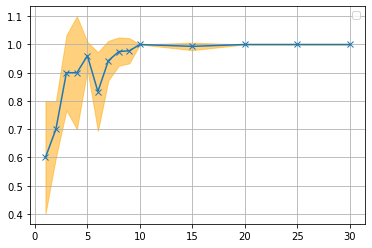

In [28]:
mean = np.mean(accuracy_train_every_run, axis=0)
standard_dev = np.std(accuracy_train_every_run, axis=0)
plt.plot(true_data_list[1:],mean[1:],marker="x")
plt.fill_between(true_data_list[1:], mean[1:]-standard_dev[1:], mean[1:]+standard_dev[1:], alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [29]:
len(accuracy_test_every_run),len(accuracy_test_every_run[0]),np.mean(accuracy_test_every_run,axis=0),np.std(accuracy_test_every_run,axis=0)


(5, 15, array([0.568, 0.557, 0.657, 0.864, 0.9  , 0.89 , 0.792, 0.901, 0.943,
        0.921, 0.968, 0.965, 1.   , 1.   , 1.   ]), array([0.09102747, 0.10906879, 0.12932904, 0.13249151, 0.15430489,
        0.09549869, 0.12520383, 0.07787169, 0.0776917 , 0.08569714,
        0.02925748, 0.04626013, 0.        , 0.        , 0.        ]))

No handles with labels found to put in legend.


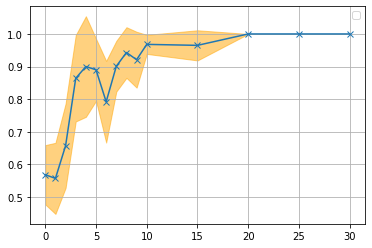

In [31]:
mean = np.mean(accuracy_test_every_run, axis=0)
standard_dev = np.std(accuracy_test_every_run, axis=0)
plt.plot(true_data_list,mean,marker="x")
plt.fill_between(true_data_list, mean-standard_dev, mean+standard_dev, alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [32]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        
        self.linear1 = nn.Linear(2,2)
        
    def forward(self,x):
        x = self.linear1(x)
        return x

In [ ]:
random_seeds = [1234,1235,1236,1237,1238]
accuracy_train_every_runl = []
accuracy_test_every_runl = []
for k in random_seeds:
  train_data_accl = []
  test_data_accl = []
  true_data_list = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30]
  for i in true_data_list:
    print("True data points for two clusters are ", 2*i)
    X_train,Y_train,train_index = create_data(7,30,i,normalize=True,rseed=1234)
    print("unique classes in Y_train",np.unique(Y_train))

    X_test,Y_test,test_index = create_data(7,100,100,test_data=True,normalize=True,rseed=1235)
    
    
    # scatter plot the given data
    plt.figure(figsize=(6,6))
    plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = "class_0")
    plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = "class_1")


    # create dataloader and dataset
    trainset = Grid_data(X_train,Y_train)
    trainloader = DataLoader(trainset,batch_size=30,shuffle = False)

    testset = Grid_data(X_test,Y_test)
    testloader = DataLoader(testset,batch_size=512,shuffle = False)


    # network instantiation
    torch.random.manual_seed(k)
    net = Net1()
    # net(inputs)
    net = net.to("cuda")


    # define cross entropy loss and optimizer
    criterion = nn.CrossEntropyLoss()
    lr=0.001
    optimizer = optim.Adam(net.parameters(), lr)#, momentum=0.9)

    net, train_true_acc, test_true_acc= train_model(net,optimizer,criterion,trainloader,testloader,train_index,test_index,epochs_nos=200)
    plot_decision_boundary(net,X_train,Y_train,fname="linear_train_db")

    train_data_accl.append(train_true_acc)
    test_data_accl.append(test_true_acc)
  accuracy_train_every_runl.append(train_data_accl)
  accuracy_test_every_runl.append(test_data_accl)


In [34]:
data = {"train":accuracy_train_every_runl,"test":accuracy_test_every_runl}
np.save("net_5runs_30_linear_1.npy",data)

In [35]:
len(accuracy_train_every_runl),len(accuracy_train_every_runl[0]),np.mean(accuracy_train_every_runl,axis=0),np.std(accuracy_train_every_runl,axis=0)


(5, 15, array([nan, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5]), array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]))

No handles with labels found to put in legend.


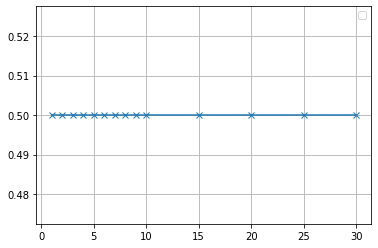

In [36]:
mean = np.mean(accuracy_train_every_runl, axis=0)
standard_dev = np.std(accuracy_train_every_runl, axis=0)
plt.plot(true_data_list[1:],mean[1:],marker="x")
plt.fill_between(true_data_list[1:], mean[1:]-standard_dev[1:], mean[1:]+standard_dev[1:], alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [37]:
len(accuracy_test_every_runl),len(accuracy_test_every_runl[0]),np.mean(accuracy_test_every_runl,axis=0),np.std(accuracy_test_every_runl,axis=0)


(5, 15, array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

No handles with labels found to put in legend.


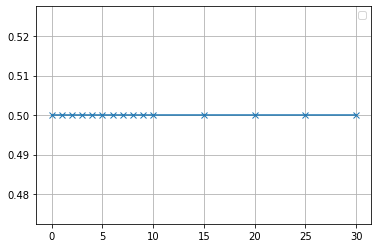

In [38]:
mean = np.mean(accuracy_test_every_runl, axis=0)
standard_dev = np.std(accuracy_test_every_runl, axis=0)
plt.plot(true_data_list,mean,marker="x")
plt.fill_between(true_data_list, mean-standard_dev, mean+standard_dev, alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        
        self.linear1 = nn.Linear(2,10000)
        self.linear2 = nn.Linear(10000,2)

        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
random_seeds = [1234,1235,1236,1237,1238]
accuracy_train_every_run_3 = []
accuracy_test_every_run_3 = []
for k in random_seeds:
  train_data_acc_3 = []
  test_data_acc_3 = []
  true_data_list = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30]
  for i in true_data_list:
    print("True data points for two clusters are ", 2*i)
    X_train,Y_train,train_index = create_data(7,30,i,normalize=True,rseed=1234)
    print("unique classes in Y_train",np.unique(Y_train))

    X_test,Y_test,test_index = create_data(7,100,100,test_data=True,normalize=True,rseed=1235)
    
    
    # scatter plot the given data
    plt.figure(figsize=(6,6))
    plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = "class_0")
    plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = "class_1")


    # create dataloader and dataset
    trainset = Grid_data(X_train,Y_train)
    trainloader = DataLoader(trainset,batch_size=30,shuffle = False)

    testset = Grid_data(X_test,Y_test)
    testloader = DataLoader(testset,batch_size=512,shuffle = False)


    # network instantiation
    torch.random.manual_seed(k)
    net = Net2()
    # net(inputs)
    net = net.to("cuda")


    # define cross entropy loss and optimizer
    criterion = nn.CrossEntropyLoss()
    lr=0.00001
    optimizer = optim.Adam(net.parameters(), lr)#, momentum=0.9)
    net, train_true_acc, test_true_acc= train_model(net,optimizer,criterion,trainloader,testloader,train_index,test_index,epochs_nos=100)
    plot_decision_boundary(net,X_train,Y_train)

    train_data_acc_3.append(train_true_acc)
    test_data_acc_3.append(test_true_acc)
  accuracy_train_every_run_3.append(train_data_acc_3)
  accuracy_test_every_run_3.append(test_data_acc_3)


In [ ]:
data = {"train":accuracy_train_every_run_3,"test":accuracy_test_every_run_3}
np.save("net_5runs_30_10000_3.npy",data)

In [ ]:
np.mean([1,1,1,0.5,1])

0.9

In [ ]:
len(accuracy_train_every_run_3),len(accuracy_train_every_run_3[0]),np.mean(accuracy_train_every_run_3,axis=0),np.std(accuracy_train_every_run_3,axis=0)


(5, 15, array([       nan, 0.5       , 0.5       , 0.5       , 0.5       ,
        0.54      , 0.5       , 0.82857143, 0.7375    , 0.74444444,
        0.84      , 0.98666667, 1.        , 1.        , 1.        ]), array([       nan, 0.        , 0.        , 0.        , 0.        ,
        0.04898979, 0.        , 0.05714286, 0.1       , 0.10304021,
        0.02      , 0.01632993, 0.        , 0.        , 0.        ]))

No handles with labels found to put in legend.


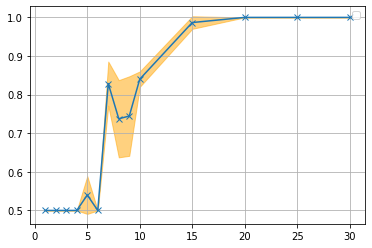

In [ ]:
mean = np.mean(accuracy_train_every_run_3, axis=0)
standard_dev = np.std(accuracy_train_every_run_3, axis=0)
plt.plot(true_data_list[1:],mean[1:],marker="x")
plt.fill_between(true_data_list[1:], mean[1:]-standard_dev[1:], mean[1:]+standard_dev[1:], alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [ ]:
len(accuracy_test_every_run_3),len(accuracy_test_every_run_3[0]),np.mean(accuracy_test_every_run_3,axis=0),np.std(accuracy_test_every_run_3,axis=0)


(5, 15, array([       nan, 0.5       , 0.5       , 0.53333333, 0.5       ,
        0.6       , 0.53333333, 0.78571429, 0.7625    , 0.68888889,
        0.76      , 0.90666667, 1.        , 1.        , 1.        ]), array([       nan, 0.        , 0.        , 0.06666667, 0.        ,
        0.        , 0.04082483, 0.0451754 , 0.04677072, 0.04444444,
        0.04898979, 0.01333333, 0.        , 0.        , 0.        ]))

No handles with labels found to put in legend.


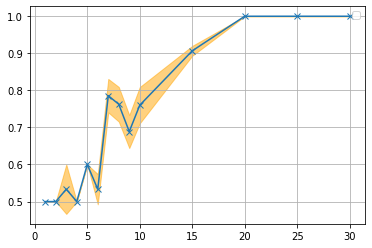

In [ ]:
mean = np.mean(accuracy_test_every_run_3, axis=0)
standard_dev = np.std(accuracy_test_every_run_3, axis=0)
plt.plot(true_data_list,mean,marker="x")
plt.fill_between(true_data_list, mean-standard_dev, mean+standard_dev, alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [39]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3,self).__init__()
        
        self.linear1 = nn.Linear(2,1000)
        self.linear2 = nn.Linear(1000,1000)
        self.linear3 = nn.Linear(1000,1000)
        self.linear4 = nn.Linear(1000,2)

        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [ ]:
random_seeds = [1234,1235,1236,1237,1238]
accuracy_train_every_run_4 = []
accuracy_test_every_run_4 = []
for k in random_seeds:
  train_data_acc_4 = []
  test_data_acc_4 = []
  true_data_list = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30] #[8]
  for i in true_data_list:
    print("True data points for two clusters are ", 2*i)
    X_train,Y_train,train_index = create_data(7,30,i,normalize=True,rseed=1234)
    print("unique classes in Y_train",np.unique(Y_train))

    X_test,Y_test,test_index = create_data(7,100,100,test_data=True,normalize=True,rseed=1235)
    
    
    # scatter plot the given data
    plt.figure(figsize=(6,6))
    plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = "class_0")
    plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = "class_1")


    # create dataloader and dataset
    trainset = Grid_data(X_train,Y_train)
    trainloader = DataLoader(trainset,batch_size=30,shuffle = False)

    testset = Grid_data(X_test,Y_test)
    testloader = DataLoader(testset,batch_size=512,shuffle = False)


    # network instantiation
    torch.random.manual_seed(k)
    net = Net3()
    # net(inputs)
    net = net.to("cuda")


    # define cross entropy loss and optimizer
    criterion = nn.CrossEntropyLoss()
    lr=0.0001
    optimizer = optim.Adam(net.parameters(), lr)#, momentum=0.9)
    net, train_true_acc, test_true_acc= train_model(net,optimizer,criterion,trainloader,testloader,train_index,test_index,epochs_nos=200)
    plot_decision_boundary(net,X_train,Y_train,fname="complex_train_db")

    train_data_acc_4.append(train_true_acc)
    test_data_acc_4.append(test_true_acc)
  accuracy_train_every_run_4.append(train_data_acc_4)
  accuracy_test_every_run_4.append(test_data_acc_4)


In [41]:
data = {"train":accuracy_train_every_run_4,"test":accuracy_test_every_run_4}
np.save("net_5runs_30_3_1000_1.npy",data)

In [42]:
len(accuracy_train_every_run_4),len(accuracy_train_every_run_4[0]),np.mean(accuracy_train_every_run_4,axis=0),np.std(accuracy_train_every_run_4,axis=0)


(5, 15, array([       nan, 1.        , 0.95      , 0.93333333, 0.975     ,
        1.        , 1.        , 0.91428571, 1.        , 1.        ,
        0.98      , 1.        , 1.        , 0.992     , 1.        ]), array([       nan, 0.        , 0.1       , 0.13333333, 0.05      ,
        0.        , 0.        , 0.17142857, 0.        , 0.        ,
        0.04      , 0.        , 0.        , 0.00979796, 0.        ]))

No handles with labels found to put in legend.


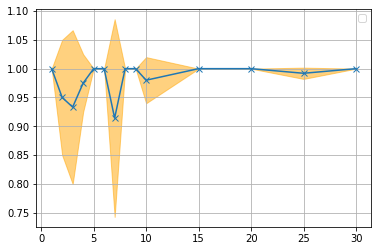

In [43]:
mean = np.mean(accuracy_train_every_run_4, axis=0)
standard_dev = np.std(accuracy_train_every_run_4, axis=0)
plt.plot(true_data_list[1:],mean[1:],marker="x")
plt.fill_between(true_data_list[1:], mean[1:]-standard_dev[1:], mean[1:]+standard_dev[1:], alpha = 0.5,color="orange")

plt.grid()
plt.legend()

In [44]:
len(accuracy_test_every_run_4),len(accuracy_test_every_run_4[0]),np.mean(accuracy_test_every_run_4,axis=0),np.std(accuracy_test_every_run_4,axis=0)


(5, 15, array([0.57 , 0.838, 0.92 , 0.97 , 0.973, 0.953, 0.977, 0.931, 0.994,
        0.99 , 0.974, 0.993, 0.994, 0.988, 1.   ]), array([0.13367872, 0.09410632, 0.05449771, 0.05282045, 0.00979796,
        0.01989975, 0.00509902, 0.07914544, 0.00374166, 0.01140175,
        0.04017462, 0.0116619 , 0.00734847, 0.01122497, 0.        ]))

No handles with labels found to put in legend.


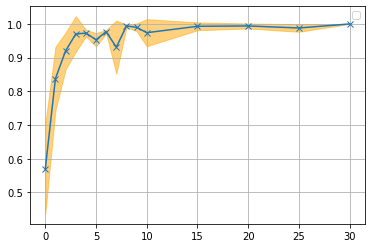

In [45]:
mean = np.mean(accuracy_test_every_run_4, axis=0)
standard_dev = np.std(accuracy_test_every_run_4, axis=0)
plt.plot(true_data_list,mean,marker="x")
plt.fill_between(true_data_list, mean-standard_dev, mean+standard_dev, alpha = 0.5,color="orange")

plt.grid()
plt.legend()